In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

import numpy as np
import scipy.stats as sp

import math
from collections import namedtuple
from functools import partial

In [2]:
data = pd.read_csv("chips.txt", header = None)

X = data.values[:,:2]
Y = data.values[:,2]

np.random.seed(0)
block_n = 10
permutation_n = 5
random_permutations = [np.random.permutation(len(X)) for _ in range(permutation_n)]

In [3]:
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])

Params = namedtuple("Params", "k norm trans kernel")

In [4]:
step = 0.01
x_min, y_min = np.amin(X, axis = 0) - step
x_max, y_max = np.amax(X, axis = 0) + step

In [5]:
def estimate(X, Y, point, params):
    distances = params.norm(X - point, axis = -1)
    dist_arg_sorted = np.argsort(distances)
    norm_distance = distances[dist_arg_sorted[params.k + 1]]
    
    ys = np.unique(Y)
    scores = [np.sum(params.kernel(distances / norm_distance) * (Y == y))
              for y in ys]
    
    return ys[np.argmax(scores)]

In [6]:
def cross_validate(X, Y, estimate, block_n, permutations):
#     accuracy = 0
    f1_sum = 0
    for permutation in permutations:
        x_parts = np.array_split(X[permutation], block_n)
        y_parts = np.array_split(Y[permutation], block_n)
        for i in range(block_n):
            x_train = np.concatenate(np.delete(x_parts, i, 0))
            y_train = np.concatenate(np.delete(y_parts, i, 0))
            x_test = x_parts[i]
            y_test = y_parts[i]
            
            test_accuracy = 0
            true_positive = 0
            false_positive = 0
            positive = np.sum(y_test == 1)
            
            for x, y in zip(x_test, y_test):
                prediction = estimate(x_train, y_train, x)
#                 test_accuracy += (prediction == y)
                true_positive += (prediction == 0 and y == 0)
                false_positive += (prediction == 0 and y == 1)
            
#             accuracy += test_accuracy / len(x_test)
            
            if true_positive != 0:
                recall = true_positive / positive
                precision = true_positive / (true_positive + false_positive)
                f1 = 2 * precision * recall / (precision + recall)
                f1_sum += f1
            
#     accuracy /= block_n * len(permutations)
    f1_sum /= block_n * len(permutations)
    
    return f1_sum

In [7]:
def identity(x):
    return x

def polar(x):
    return np.column_stack([
        np.sqrt(x[:,0] ** 2 + x[:,1] ** 2),
        np.arctan2(x[:,1], x[:,0])
    ])

def withPolar(x):
    return np.concatenate([x, polar(x)], axis = 1)

def withRadius(x):
    x = x - np.average(x, axis = 0)
    return np.column_stack([
        x[:,0],
        x[:,1],
        np.sqrt(x[:,0] ** 2 + x[:,1] ** 2)
    ])

def withSqr(x):
    x = x - np.average(x, axis = 0)
    return np.column_stack([
        x[:,0],
        x[:,1],
        x[:,0] ** 2,
        x[:,1] ** 2,
        x[:,0] * x[:,1]
    ])

def with3(x):
    x = x - np.average(x, axis = 0)
    return np.column_stack([
        x[:,0],
        x[:,1],
        x[:,0] ** 3,
        x[:,0] ** 2 * x[:,1],
        x[:,0] * x[:,1] ** 2,
        x[:,1] ** 3
    ])


def kernelConst(x):
    return (np.abs(x) < 1.0) * 0.5

def kernelTriangle(x):
    xabs = np.abs(x)
    return (xabs < 1.0) * (1.0 - xabs)

def kernelEpanechnikov(x):
    return 0.75 * (1.0 - x ** 2.0) * (np.abs(x) < 1.0)


params_set = [
    Params(k, partial(np.linalg.norm, ord = norm_ord), trans_f, kernel_f)
    for k in np.arange(2, round(math.sqrt(len(X)) + 1))
    for norm_ord in [
        1, 
        1.5, 
        2, 
        np.inf
    ]
    for trans_f in [
        identity,
        withSqr,
        withRadius,
        with3,
        polar,
        withPolar
    ]
    # Parzen-Rosenblatt window with variable window width
    for kernel_f in [
        kernelConst,
        kernelTriangle,
        kernelEpanechnikov
    ]
]

In [8]:
params_accuracies = [cross_validate(p.trans(X), Y, partial(estimate, params = p), block_n, random_permutations)
                     for p in params_set]

In [9]:
best_params = params_set[np.argmax(params_accuracies)]
print(cross_validate(best_params.trans(X), Y, partial(estimate, params=best_params), block_n, random_permutations))
print(best_params)

0.820339216339
Params(k=10, norm=functools.partial(<function norm at 0x7f9238273b70>, ord=1.5), trans=<function withRadius at 0x7f921688f950>, kernel=<function kernelConst at 0x7f921688fb70>)


In [10]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                     np.arange(y_min, y_max, step))
transX = best_params.trans(X)
transPoints = best_params.trans(np.column_stack([xx.reshape((-1)), yy.reshape((-1))]))
zz = np.array([estimate(transX, Y, p, best_params)
               for p in transPoints]
             ).reshape(xx.shape)

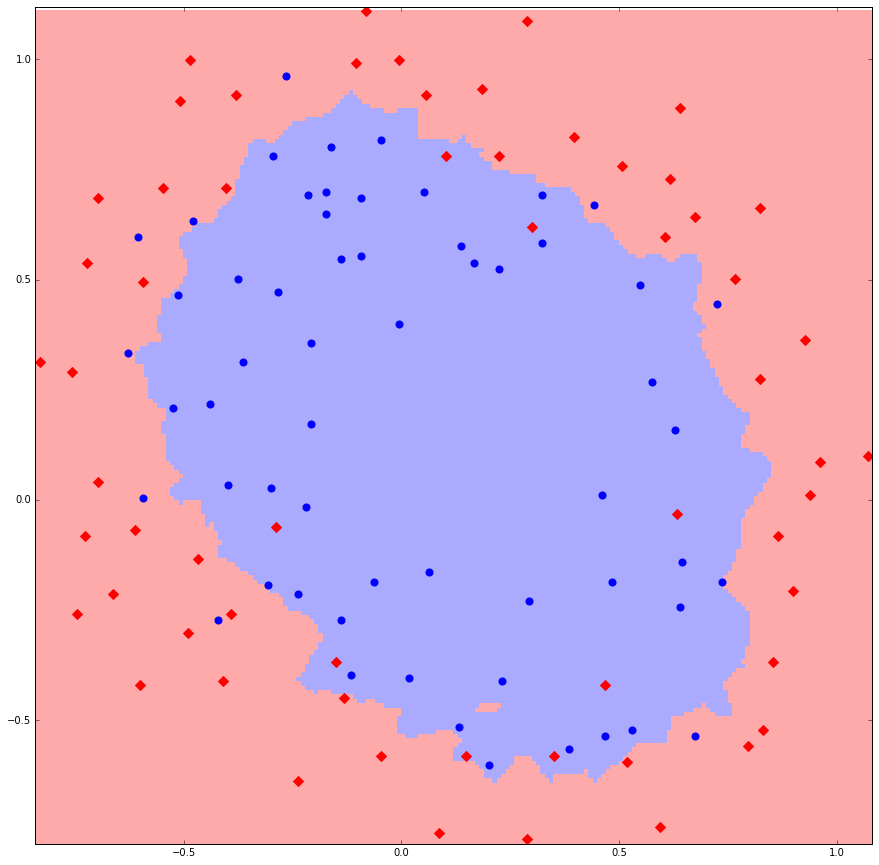

In [11]:
plt.figure(figsize=(15, 15))
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

x0, y0 = X[Y == 0].T
x1, y1 = X[Y == 1].T

plt.pcolormesh(xx, yy, zz, cmap = cmap_light)
plt.scatter(x0, y0, marker = 'D', color = 'red',  s = 50)
plt.scatter(x1, y1, marker = 'o', color = 'blue', s = 50)